**Other02 liner mode to compare(not necessary,only for watching and compare)(PS:Download on the server offer by the match organization is prohibit,so the effect of code is only can be showed by screenshot of running on server.)**

**In the case of using n*24-hour sliding window prediction and improved mape loss function, even if the linear model is used, a good result of 0.2665 can be obtained. (screenshot shown in the end of code).Linear model training and prediction takes 2 hours of CPU**

**线性模型效果对比（不重要，只是为了观察和比较）（备注：因赛事方比赛服务器限制所有下载，部分代码效果只有对服务器代码运行截图显示，参见代码部分。）**

**在采用n*24小时滑窗预测和改进的mape损失函数情况下，采用线性模型，只需使用CPU训练及预测所有地市全部小区时长仅需2小时左右，也能达到预测结果0.2565（mape)。(参见代码最后截图)**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import pickle
import zipfile
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

**Only use CPU here**

**可以看到这里只使用CPU**

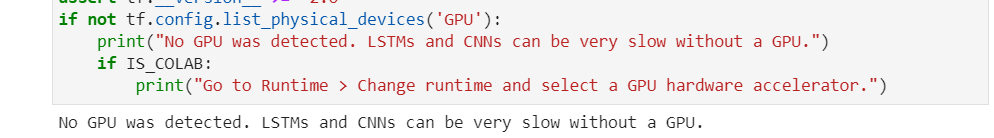截图17

In [ ]:
def log_txt(data_str,file_path = "./log/log_back_up_line21new.txt"):
    with open(file_path,"a") as file:   #只需要将之前的”w"改为“a"即可，代表追加内容
        file.write(data_str + "d" + " "+"\n")

In [ ]:
start_time = datetime.datetime.now()
log_str = 'start_time is {}'.format(start_time)
print(log_str)
log_txt(log_str)

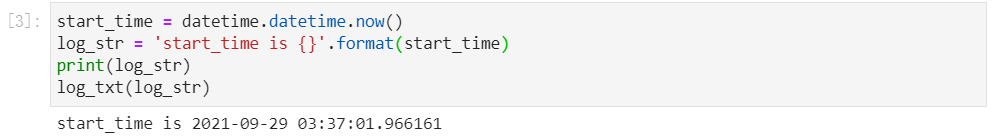
截图18

In [ ]:
city_list = ['C48FDFBFC4072E0E','AFE97F546A10368F','EA5EAA705108BDA0','F37F452354AC87C9']
timestamp_column = "TimeStamp"
userlabel_column = "UserLabel"
G4_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
G5_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
time_format = "%Y-%m-%d %H:%M:%S"
data_col_dict = {'上行利用率PUSCH':'PUSCH','下行利用率PDSCH':'PDSCH','有效RRC连接平均数':'RRC',
                             '下行流量':'PDCPDL','上行流量':'PDCPUL','下行利用率PDCCH':'PDCCH','有数据传输的RRC数':'RRC'}
n_steps = 21
n_pred = 7

In [ ]:
def pic_to_pd(file_path,select_data_column,float_type):
    print('begin to get data from {}'.format(file_path))
    file=open(file_path,'rb')
    df = pickle.load(file)
    file.close()
    select_columns = ["TimeStamp","UserLabel"]
    select_columns.append(select_data_column)
    df= df[select_columns]
    df.dropna(inplace = True)
    df.reset_index(drop = True,inplace = True)
    df[select_data_column] = df[select_data_column].astype(float_type)
    #df.loc[:,"TimeStamp_orgin"] = df[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
    return df

In [ ]:
def pic_to_pd_train(train_file_path,test_file_path,select_data_column,float_type,select_cell_list = False):
    df_train = pic_to_pd(train_file_path,select_data_column,float_type)
    df_test = pic_to_pd(test_file_path,select_data_column,float_type)
    train_cell_set = set(df_train["UserLabel"].unique())
    test_cell_set = set(df_test["UserLabel"].unique())
    if select_cell_list == False:
        choose_cell_set = list(train_cell_set & test_cell_set)
    else:
        select_cell_set = set(select_cell_list)
        choose_cell_set = list(select_cell_set & train_cell_set & test_cell_set)
    print('use to train cells num is {}'.format(len(choose_cell_set)))
    df_train = df_train.query("UserLabel in {}".format(choose_cell_set))
    df_test = df_test.query("UserLabel in {}".format(choose_cell_set))
    df = pd.concat([df_train,df_test])
    df.reset_index(drop = True,inplace = True)
    return df,choose_cell_set,len(choose_cell_set)

In [ ]:
def pd_to_npdata(df,select_data_column,train_month = False,user_num = False,n_steps = 21,n_pred = 7):
    print('begin to trun pandas data to train data')
    df['month'] = df['TimeStamp'].apply(lambda x: int(x[5:7]))
    if train_month == False:
        train_month == df['month'].min()
    if user_num == False:
        user_num = len(df["UserLabel"].unique())
    train_day_num = (df['month'] == train_month).sum()
    data_start_row = train_day_num - user_num * n_steps * 24
    print('data_start_row is {}'.format(data_start_row))
    data_end_row = data_start_row + user_num * (n_steps + n_pred) * 24 - 1
    print(' data_end_row is {}'.format( data_end_row))
    df = df.loc[data_start_row:data_end_row]
    df.drop('month',axis = 1)
    df.reset_index(drop = True,inplace = True)
    df['hour'] = df['TimeStamp'].apply(lambda x: int(x[11:13]))
    df.sort_values(["hour","TimeStamp","UserLabel"],inplace = True)
    df.reset_index(drop = True,inplace = True)
    print('begin to creat X_train Y_train index_Y_train')
    X_train_list = []
    Y_train_list = []
    index_Y_train_list = []
    for time_order in range(24):
        print("now time_order is {}".format(time_order))
        start_row = time_order * user_num * (n_steps + n_pred)
        end_x_low = start_row + n_steps * user_num - 1
        X_train_list.append(df.loc[start_row:end_x_low,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1))
        start_y_row = end_x_low + 1
        end_y_low =  start_y_row + n_pred * user_num - 1
        Y_train_list.append(df.loc[start_y_row:end_y_low,select_data_column].values
                            .reshape(n_pred,user_num).T.reshape(user_num,n_pred))
        index_Y_train_list.append(df.loc[end_x_low + 1:end_x_low + user_num,["TimeStamp","UserLabel"]])
    X_train = np.concatenate(X_train_list, axis=0)
    del(X_train_list)
    Y_train = np.concatenate(Y_train_list, axis=0)
    del(Y_train_list)
    index_Y_train = pd.concat(index_Y_train_list)
    index_Y_train.reset_index(drop = True,inplace = True)
    del(index_Y_train_list)
    return X_train,Y_train,index_Y_train

In [ ]:
def pd_to_npdata_test(test_file_path,select_data_column,float_type,test_month = False,n_steps = 21):
    df = pic_to_pd(test_file_path,select_data_column,float_type)
    print('begin to trun pandas data to test data')
    df['month'] = df['TimeStamp'].apply(lambda x: int(x[5:7]))
    if test_month == False:
        test_month = df['month'].min()
    user_num = len(df["UserLabel"].unique())
    test_day_num = (df['month'] == test_month).sum()
    data_start_row = test_day_num - user_num * n_steps * 24
    data_end_row = data_start_row + user_num * n_steps * 24 - 1
    df = df.loc[data_start_row:data_end_row]
    df.drop('month',axis = 1)
    df.reset_index(drop = True,inplace = True)
    df['hour'] = df['TimeStamp'].apply(lambda x: int(x[11:13]))
    df.sort_values(["hour","TimeStamp","UserLabel"],inplace = True)
    df.reset_index(drop = True,inplace = True)
    print('begin to creat X_test index_X_test')
    X_test_list = []
    index_X_test_list = []
    for time_order in range(24):
        print("now time_order is {}".format(time_order))
        start_row = time_order * user_num * n_steps
        end_x_low = start_row + n_steps * user_num - 1
        X_test_list.append(df.loc[start_row:end_x_low,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1))
        index_X_test_list.append(df.loc[start_row:start_row + user_num,["UserLabel","hour"]])
    X_test = np.concatenate(X_test_list, axis=0)
    del(X_test_list)
    index_X_test = pd.concat(index_X_test_list)
    index_X_test.reset_index(drop = True,inplace = True)
    del(index_X_test_list)
    return X_test,index_X_test

In [ ]:
def all_data_scaler(data_list,scale_param_in = False):
    print('begin to scaler data')
    data_shape_list = []
    for i in range(len(data_list)):
        data_shape_list.append(np.array(data_list[i]).shape)
        data_list[i] = np.array(data_list[i]).reshape(-1,1)
        if i==0:
            if scale_param_in == False:
                scaler = MinMaxScaler()
                scale_param = scaler.fit(data_list[0])
            else:
                scale_param = scale_param_in
        data_list[i] = scale_param.transform(data_list[i])
        data_list[i] = data_list[i].reshape(data_shape_list[i])
    return(data_list,scale_param)

In [ ]:
def train_data_dump(file_path,data_list):
    file=open(file_path,"wb")
    for orgin_data in data_list:
        pickle.dump(orgin_data,file)
    file.close()

In [ ]:
def train_data_load(file_path,file_num = 6):
    data_list = []
    file=open(file_path,'rb')
    for data_order in range(file_num):
        data_list.append(pickle.load(file))
    file.close()
    return data_list

In [ ]:
def creat_mape_handel(low_discrete = 0.01 ,high_discrete = 1):
    def mape_handel(y_true, y_pred):
        error = y_pred - y_true
        mape_error_handel = tf.abs(error) / tf.clip_by_value(y_true,low_discrete,high_discrete)
        return mape_error_handel
    return mape_handel

In [ ]:
in_file = "./Datasets/cell_choose_11000new.pic"
file=open(in_file,"rb")
select_cell_dict_train = pickle.load(file)
file.close()

In [ ]:
for net_type in ['4g','5g']:
    if net_type == '4g':
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
    else:
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
    for city_name in city_list:
        train_file_path = './Datasets_new_IQR_100/{}_pm_202105_{}.pic'.format(net_type,city_name)
        test_file_path = './Datasets_new_IQR_100/{}_pm_202106_{}.pic'.format(net_type,city_name)
        for select_data_column in gselect_data_columns:
            result_data_path = './result_data_liner/{}_{}_{}.csv'.format(net_type,data_col_dict[select_data_column],city_name)
            print('begin to create {}'.format(result_data_path))
            if os.path.exists(result_data_path):
                print('there is already file {} exists'.format(result_data_path))
                continue
            out_file = "./temple_file/train_test_data_{}_{}_{}liner.pic".format(net_type,city_name,select_data_column)
            print('begin to create {}'.format(out_file))
            if os.path.exists(out_file):
                print('there is already file {} exists'.format(out_file))
                X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test = train_data_load(out_file)
            else:
                print('begin to prapare data to train')
                float_type = 'float32'
                df,choose_cell_set,user_num = pic_to_pd_train(train_file_path,test_file_path,select_data_column,float_type,
                                                  select_cell_list = select_cell_dict_train[net_type][city_name])
                X_train,Y_train,index_Y_train = pd_to_npdata(df,select_data_column,train_month = 5,user_num = user_num)
                X_test,index_X_test = pd_to_npdata_test(test_file_path,select_data_column,float_type,test_month = 6,n_steps = 21)
                del(df)
                [X_train,Y_train,X_test],scale_param = all_data_scaler([X_train,Y_train,X_test])
                train_data_dump(out_file,[X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test])
                print('{} data dump success'.format(out_file))
            scale_median = np.median(X_train)/5
            log_str = 'scale_median is {}'.format(scale_median)
            print(log_str)
            X_train_dnn, X_valid_dnn = train_test_split(X_train, test_size=0.3, random_state=2012)
            Y_train_dnn, Y_valid_dnn = train_test_split(Y_train, test_size=0.3, random_state=2012)
            del(X_train)
            del(Y_train)
            Y_pred_copy = X_valid_dnn[:,-7:,0].copy()
            Y_true_sub = Y_valid_dnn.copy()
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('-'*88)
            model_file_path = "./temple_file/{}_{}_{}_model_line21new.h5".format(net_type,select_data_column,city_name)
            if os.path.exists(model_file_path):
                print('there is already file {} exists'.format(model_file_path))
                model = keras.models.load_model(model_file_path,
                                                custom_objects = {'mape_handel':creat_mape_handel(scale_median,1)})
            else:
                patience_select = int(11000 / len(select_cell_dict_train[net_type][city_name]) * 3)
                print("patience_select is {}".format(patience_select))
                epochs_select = int(11000 / len(select_cell_dict_train[net_type][city_name])* 25)
                print("epochs_select is {}".format(epochs_select))
                np.random.seed(42)
                tf.random.set_seed(42)
                model = keras.models.Sequential([
                    keras.layers.Flatten(input_shape=[n_steps, 1]),
                    keras.layers.Dense(n_pred)
                ])
                checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path,save_best_only=True)
                early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience_select,restore_best_weights=True)
                model.compile(loss=creat_mape_handel(scale_median,1), optimizer="adam")
                history = model.fit(X_train_dnn, Y_train_dnn, epochs=epochs_select,
                                    validation_data=(X_valid_dnn, Y_valid_dnn),
                                    callbacks = [checkpoint_cb, early_stopping_cb])
            Y_pred_sub = model.predict(X_valid_dnn)
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_valid_dnn, Y_pred_sub))
            log_str = 'The line_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_true_sub = Y_valid_dnn.copy()
            Y_pred_copy = Y_pred_sub.copy()
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The line_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('='*88)
            Y_test = model.predict(X_test)
            Y_pred = scale_param.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)
            test_usenum  = int(len(Y_pred)/24)
            print('test_usenum is {}'.format(test_usenum))
            Y_pred = Y_pred.reshape(24,test_usenum,7)
            Y_pred = Y_pred.transpose((1,2,0))
            Y_pred = Y_pred.reshape(test_usenum,168)
            columns_name = []
            for order_num in range(1,169):
                columns_name.append("预测未来{}小时".format(order_num))
            sub_data = pd.DataFrame(Y_pred,columns = columns_name,index = index_X_test.UserLabel[:test_usenum])
            #指标数据不可能小于0，剔除异常预测
            sub_data[sub_data < 0] = 0
            print("begin output_data in {}".format(result_data_path))
            sub_data.to_csv(result_data_path,encoding= 'gbk')
            print("success output_data in {}".format(result_data_path))
            keras.backend.clear_session()
            del(X_train_dnn, X_valid_dnn,Y_train_dnn, Y_valid_dnn, Y_pred, X_test, Y_test)
            del(index_Y_train,index_X_test)
            del(sub_data)
            if os.path.exists(out_file):  # 如果文件存在
                # 删除文件，可使用以下两种方法。
                os.remove(out_file)
                # os.unlink(path)
            else:
                print('no such file:%s' % out_file)  # 则返回文件不存在

**liner model each sample is about 30us**

**线性模型每sample只要30us**

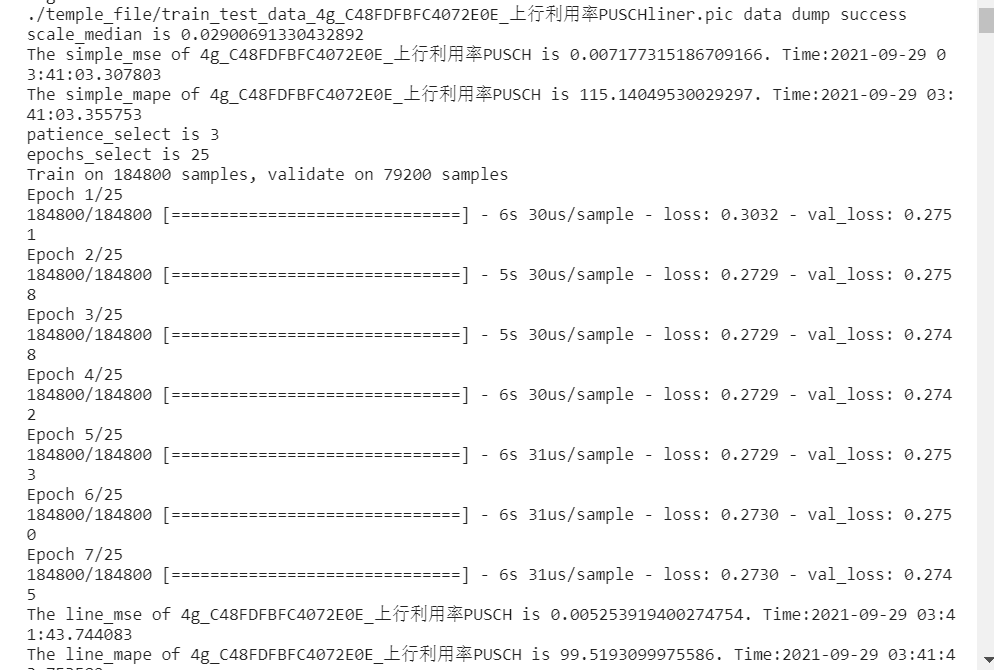截图19

In [ ]:
end_time = datetime.datetime.now()
log_str = 'end_time is {}'.format(end_time)
print(log_str)
log_txt(log_str)
all_use_time = (end_time - start_time)
log_str = 'all_use_time is {}'.format(all_use_time)
print(log_str)
log_txt(log_str)

**the end time of code running and all use time is about 2 hours**

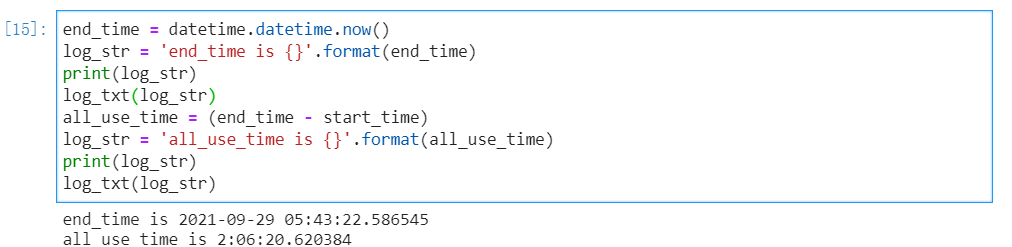
截图20

In [ ]:
def compressFolder(folderPath, compressPathName):
    '''
    :param folderPath: 文件夹路径
    :param compressPathName: 压缩包路径
    :return:
    '''
    zip = zipfile.ZipFile(compressPathName, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(folderPath):
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = "result_data" + '/' + name
            print(fullName)
            print(name)
            zip.write(fullName, name)
    zip.close()

In [ ]:
folderPath = './result_data_liner'
compressPathName = './result_data.zip'
compressFolder(folderPath, compressPathName)

In [ ]:
!curl --location --request POST 'http://36.133.53.121:1080/file/upload' --form 'cloud_id=CIDC-U-6fca7a4e9f9645f0abe69ea1df9f7e26' --form 'file=@result_data.zip'

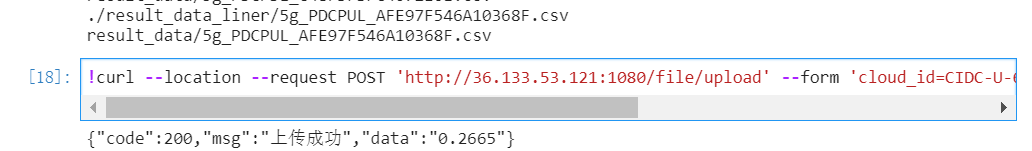